In [198]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [199]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [200]:
tf.keras.backend.clear_session()

In [201]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [202]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [203]:
subject = 'Rio Grande Do Norte - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [204]:
data = pd.read_csv('2003_mo_model_input_RN.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande Do Norte - Consumo de Cimento (t),Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego
0,2003-1,36.825,0.689488,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170
1,2003-2,34.088,0.689892,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224
2,2003-3,30.150,0.690297,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278
3,2003-4,31.224,0.690702,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332
4,2003-5,33.606,0.691107,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,83.890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.421498,1007.779364,1608.091526,26.070061,22.101245,79.387618,4.021974,95.557326,NaN,NaN,NaN,NaN,NaN
236,2022-9,83.438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.356563,1007.378337,1711.545116,26.514778,22.200015,77.727187,4.060448,94.910014,NaN,NaN,NaN,NaN,NaN
237,2022-10,80.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.303541,1007.103329,1739.491903,26.741766,22.273808,76.994273,4.055648,94.800783,NaN,NaN,NaN,NaN,NaN
238,2022-11,75.441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.255695,1006.885711,1779.585540,26.912875,22.301927,76.309067,3.958626,94.752983,NaN,NaN,NaN,NaN,NaN


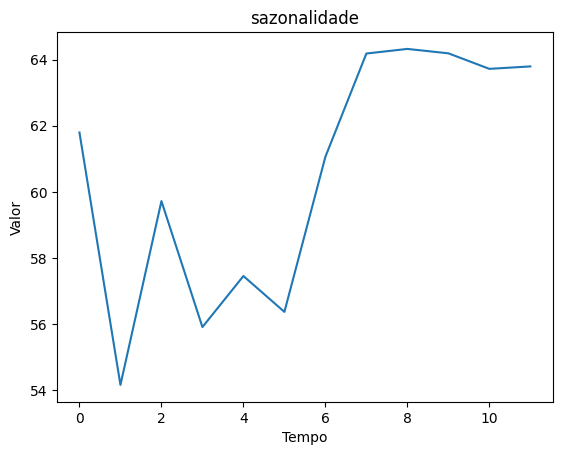

,sazonalidade
sazonalidade,
0,61.797214
1,54.166214
2,59.723464
3,55.915500
4,57.458071
5,56.374500
6,61.064000
7,64.184769
8,64.323615


In [205]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [206]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.689488,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,61.797214,36.825
1,2003-2,0.689892,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,54.166214,34.088
2,2003-3,0.690297,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,59.723464,30.150
3,2003-4,0.690702,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,55.915500,31.224
4,2003-5,0.691107,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,57.458071,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.421498,1007.779364,1608.091526,26.070061,22.101245,79.387618,4.021974,95.557326,NaN,NaN,NaN,NaN,NaN,64.184769,83.890
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.356563,1007.378337,1711.545116,26.514778,22.200015,77.727187,4.060448,94.910014,NaN,NaN,NaN,NaN,NaN,64.323615,83.438
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.303541,1007.103329,1739.491903,26.741766,22.273808,76.994273,4.055648,94.800783,NaN,NaN,NaN,NaN,NaN,64.190462,80.005
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.255695,1006.885711,1779.585540,26.912875,22.301927,76.309067,3.958626,94.752983,NaN,NaN,NaN,NaN,NaN,63.721077,75.441


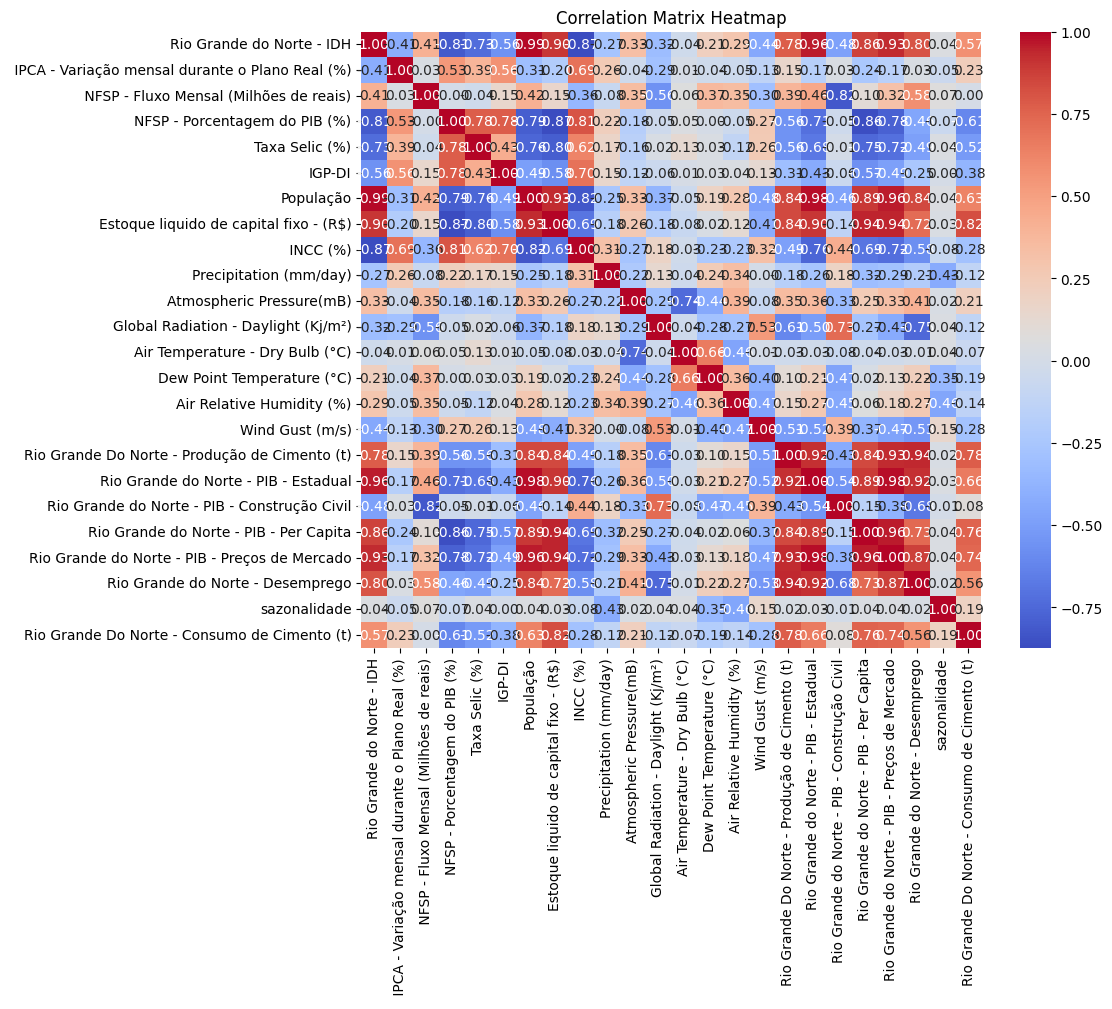

In [207]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [208]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data

,Unnamed: 0,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.689488,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,1006.950610,21.591412,5.667138,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,61.797214,36.825
1,2003-2,0.689892,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,1006.950925,21.591907,5.663569,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,54.166214,34.088
2,2003-3,0.690297,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1006.951108,21.592195,5.661487,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,59.723464,30.150
3,2003-4,0.690702,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1006.951128,21.592226,5.661264,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,55.915500,31.224
4,2003-5,0.691107,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1006.815853,21.749605,5.413625,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,57.458071,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1007.779364,22.101245,4.021974,95.557326,NaN,NaN,NaN,NaN,NaN,64.184769,83.890
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1007.378337,22.200015,4.060448,94.910014,NaN,NaN,NaN,NaN,NaN,64.323615,83.438
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1007.103329,22.273808,4.055648,94.800783,NaN,NaN,NaN,NaN,NaN,64.190462,80.005
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1006.885711,22.301927,3.958626,94.752983,NaN,NaN,NaN,NaN,NaN,63.721077,75.441


In [209]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,sazonalidade
0,-2.184058,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.244116,-0.443310,0.959558,-1.183161,-1.731345,-0.778207,-2.784513,-2.193066,-0.876481,0.346623
1,-2.147573,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.243762,-0.442426,0.955853,-1.192364,-1.711183,-0.728728,-2.703361,-2.146603,-0.878896,-1.790374
2,-2.111089,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.243555,-0.441911,0.953691,-1.193319,-1.691021,-0.679248,-2.622210,-2.100140,-0.881311,-0.234113
3,-2.074605,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.243533,-0.441856,0.953460,-1.188108,-1.670859,-0.629768,-2.541059,-2.053677,-0.883727,-1.300501
4,-2.038120,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.395830,-0.160742,0.696372,-1.175380,-1.650697,-0.580289,-2.459908,-2.007214,-0.886142,-0.868517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.321156,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,1.112250,-0.165163,-0.330234,0.389536,1.102751,-1.573216,0.457957,0.775635,1.052347,1.015237
188,1.314269,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,0.579226,0.164483,-0.313703,0.398528,1.092237,-1.561825,0.427807,0.759230,1.051753,1.054120
189,1.307381,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.279753,0.608997,-0.364992,0.414978,1.081724,-1.550435,0.397658,0.742826,1.051160,1.016831
190,1.300494,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-0.100219,1.289330,-0.534769,0.429834,1.071210,-1.539044,0.367509,0.726421,1.050566,0.885384


In [210]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      32.845
1      26.809
2      34.465
3      30.563
4      32.574
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 240, dtype: float64

In [211]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,sazonalidade
0,-2.184058,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.244116,-0.443310,0.959558,-1.183161,-1.731345,-0.778207,-2.784513,-2.193066,-0.876481,0.346623
1,-2.147573,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.243762,-0.442426,0.955853,-1.192364,-1.711183,-0.728728,-2.703361,-2.146603,-0.878896,-1.790374
2,-2.111089,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.243555,-0.441911,0.953691,-1.193319,-1.691021,-0.679248,-2.622210,-2.100140,-0.881311,-0.234113
3,-2.074605,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.243533,-0.441856,0.953460,-1.188108,-1.670859,-0.629768,-2.541059,-2.053677,-0.883727,-1.300501
4,-2.038120,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.395830,-0.160742,0.696372,-1.175380,-1.650697,-0.580289,-2.459908,-2.007214,-0.886142,-0.868517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.384282,-0.214006,1.216560,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,0.078219,2.224095,-0.769210,1.046207,1.183768,-1.442416,0.625176,0.985411,1.213189,-1.790374
158,1.382302,-0.434717,1.155373,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,0.503268,2.086497,-0.842268,1.000373,1.187707,-1.461501,0.642268,0.990347,1.201976,-0.234113
159,1.380323,-0.524091,1.056140,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,0.941127,1.525954,-0.780971,0.957199,1.191647,-1.480587,0.659360,0.995283,1.190764,-1.300501
160,1.378343,-0.614500,1.147619,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,1.653838,0.735444,-0.703275,0.908410,1.195587,-1.499673,0.676453,1.000219,1.179551,-0.868517


In [212]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      32.845
1      26.809
2      34.465
3      30.563
4      32.574
        ...  
157    52.722
158    63.109
159    49.356
160    55.725
161    50.796
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 162, dtype: float64

In [213]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [214]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 19)

In [215]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Norte - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,sazonalidade
126,0.458594,0.888984,-0.230612,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,1.227689,-0.710100,-0.520793,1.480898,0.826780,0.124108,0.924042,0.982707,1.063612,0.141293
127,0.463887,0.954254,-0.156322,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,0.903715,-0.841255,-0.309572,1.485581,0.843350,0.061862,0.903284,0.982590,1.075867,1.015237
128,0.469179,1.045217,-0.120008,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,0.566054,-0.705983,-0.277418,1.491421,0.859920,-0.000383,0.882526,0.982474,1.088122,1.054120
129,0.474472,1.176395,-0.143194,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,0.144491,-0.579899,-0.245210,1.490890,0.876489,-0.062629,0.861768,0.982357,1.100376,1.016831
130,0.479764,1.303259,-0.028712,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,-0.414682,-0.264196,-0.380170,1.486995,0.893059,-0.124874,0.841010,0.982241,1.112631,0.885384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.321156,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,1.112250,-0.165163,-0.330234,0.389536,1.102751,-1.573216,0.457957,0.775635,1.052347,1.015237
188,1.314269,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,0.579226,0.164483,-0.313703,0.398528,1.092237,-1.561825,0.427807,0.759230,1.051753,1.054120
189,1.307381,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.279753,0.608997,-0.364992,0.414978,1.081724,-1.550435,0.397658,0.742826,1.051160,1.016831
190,1.300494,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,-0.100219,1.289330,-0.534769,0.429834,1.071210,-1.539044,0.367509,0.726421,1.050566,0.885384


In [216]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 19)

In [217]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [218]:
# Rede Neural Recorrente com optmizador Estocástico
def bidirectional_lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True, 
                                      input_shape=(train_input.shape[1], train_input.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [219]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(2)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [220]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[373089985, 3832614216]


Step: 0 ___________________________________________
val_loss: 145.3769989013672
winner_seed: 373089985


Step: 1 ___________________________________________
val_loss: 145.37745666503906


final_seed: 373089985


In [221]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 137ms/step - loss: 4974.3369 - val_loss: 4924.9365
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 4931.5444 - val_loss: 4879.2456
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 4880.8164 - val_loss: 4822.4702
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 4823.3926 - val_loss: 4753.1484
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 4752.3013 - val_loss: 4676.6343
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 4676.2231 - val_loss: 4596.2236
Epoch 7/10000
4/4 [==============================] - 0s 13ms/step - loss: 4595.7354 - val_loss: 4516.1528
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 4519.2583 - val_loss: 4446.6577
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 4456.2983 - val_loss: 4390.9668
Epoch 10/10000
4/4 [=========================

Epoch 78/10000
4/4 [==============================] - 0s 10ms/step - loss: 3554.8511 - val_loss: 3527.4343
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 3545.8870 - val_loss: 3518.2712
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 3536.2415 - val_loss: 3509.1616
Epoch 81/10000
4/4 [==============================] - 0s 11ms/step - loss: 3527.9717 - val_loss: 3500.0625
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 3518.0522 - val_loss: 3490.9675
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 3508.5747 - val_loss: 3481.8992
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 3499.8972 - val_loss: 3472.8826
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 3491.0530 - val_loss: 3463.9165
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 3481.7126 - val_loss: 3454.9773
Epoch 87/10000
4/4 [=================

4/4 [==============================] - 0s 11ms/step - loss: 2924.3040 - val_loss: 2898.9214
Epoch 155/10000
4/4 [==============================] - 0s 10ms/step - loss: 2917.1055 - val_loss: 2891.3962
Epoch 156/10000
4/4 [==============================] - 0s 9ms/step - loss: 2909.3943 - val_loss: 2883.8965
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 2901.9043 - val_loss: 2876.4097
Epoch 158/10000
4/4 [==============================] - 0s 10ms/step - loss: 2894.4182 - val_loss: 2868.9304
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 2886.9558 - val_loss: 2861.4910
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 2879.6528 - val_loss: 2854.0522
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 2871.8845 - val_loss: 2846.6416
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 2864.7615 - val_loss: 2839.2334
Epoch 163/10000
4/4 [==========================

4/4 [==============================] - 0s 11ms/step - loss: 2396.5857 - val_loss: 2371.9678
Epoch 231/10000
4/4 [==============================] - 0s 10ms/step - loss: 2389.7410 - val_loss: 2365.6147
Epoch 232/10000
4/4 [==============================] - 0s 10ms/step - loss: 2383.1467 - val_loss: 2359.2578
Epoch 233/10000
4/4 [==============================] - 0s 11ms/step - loss: 2376.8149 - val_loss: 2352.9399
Epoch 234/10000
4/4 [==============================] - 0s 10ms/step - loss: 2370.4380 - val_loss: 2346.6184
Epoch 235/10000
4/4 [==============================] - 0s 11ms/step - loss: 2364.4109 - val_loss: 2340.2827
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 2358.1399 - val_loss: 2333.9824
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 2351.9258 - val_loss: 2327.6995
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 2345.5864 - val_loss: 2321.4114
Epoch 239/10000
4/4 [=======================

4/4 [==============================] - 0s 10ms/step - loss: 1947.8152 - val_loss: 1924.9232
Epoch 307/10000
4/4 [==============================] - 0s 13ms/step - loss: 1942.5570 - val_loss: 1919.5288
Epoch 308/10000
4/4 [==============================] - 0s 10ms/step - loss: 1937.2693 - val_loss: 1914.1384
Epoch 309/10000
4/4 [==============================] - 0s 9ms/step - loss: 1931.6650 - val_loss: 1908.7391
Epoch 310/10000
4/4 [==============================] - 0s 9ms/step - loss: 1926.2163 - val_loss: 1903.4026
Epoch 311/10000
4/4 [==============================] - 0s 10ms/step - loss: 1921.1621 - val_loss: 1898.0269
Epoch 312/10000
4/4 [==============================] - 0s 11ms/step - loss: 1915.7319 - val_loss: 1892.6931
Epoch 313/10000
4/4 [==============================] - 0s 11ms/step - loss: 1910.3019 - val_loss: 1887.3442
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 1904.9651 - val_loss: 1882.0200
Epoch 315/10000
4/4 [=========================

4/4 [==============================] - 0s 9ms/step - loss: 1569.1125 - val_loss: 1546.9725
Epoch 383/10000
4/4 [==============================] - 0s 11ms/step - loss: 1564.7319 - val_loss: 1542.4124
Epoch 384/10000
4/4 [==============================] - 0s 12ms/step - loss: 1560.0253 - val_loss: 1537.8784
Epoch 385/10000
4/4 [==============================] - 0s 11ms/step - loss: 1555.5256 - val_loss: 1533.3477
Epoch 386/10000
4/4 [==============================] - 0s 9ms/step - loss: 1550.7664 - val_loss: 1528.8462
Epoch 387/10000
4/4 [==============================] - 0s 9ms/step - loss: 1546.1033 - val_loss: 1524.3480
Epoch 388/10000
4/4 [==============================] - 0s 10ms/step - loss: 1541.7001 - val_loss: 1519.8484
Epoch 389/10000
4/4 [==============================] - 0s 10ms/step - loss: 1537.2581 - val_loss: 1515.3641
Epoch 390/10000
4/4 [==============================] - 0s 11ms/step - loss: 1532.9824 - val_loss: 1510.8815
Epoch 391/10000
4/4 [==========================

4/4 [==============================] - 0s 10ms/step - loss: 1251.0836 - val_loss: 1230.0786
Epoch 459/10000
4/4 [==============================] - 0s 9ms/step - loss: 1247.3037 - val_loss: 1226.2870
Epoch 460/10000
4/4 [==============================] - 0s 10ms/step - loss: 1243.6522 - val_loss: 1222.4919
Epoch 461/10000
4/4 [==============================] - 0s 9ms/step - loss: 1239.8978 - val_loss: 1218.7378
Epoch 462/10000
4/4 [==============================] - 0s 10ms/step - loss: 1236.1233 - val_loss: 1214.9479
Epoch 463/10000
4/4 [==============================] - 0s 11ms/step - loss: 1232.3999 - val_loss: 1211.1832
Epoch 464/10000
4/4 [==============================] - 0s 11ms/step - loss: 1228.3994 - val_loss: 1207.4614
Epoch 465/10000
4/4 [==============================] - 0s 11ms/step - loss: 1224.7798 - val_loss: 1203.7061
Epoch 466/10000
4/4 [==============================] - 0s 10ms/step - loss: 1221.1835 - val_loss: 1199.9818
Epoch 467/10000
4/4 [=========================

4/4 [==============================] - 0s 9ms/step - loss: 987.9787 - val_loss: 967.6183
Epoch 535/10000
4/4 [==============================] - 0s 9ms/step - loss: 984.8760 - val_loss: 964.5087
Epoch 536/10000
4/4 [==============================] - 0s 10ms/step - loss: 981.7497 - val_loss: 961.3845
Epoch 537/10000
4/4 [==============================] - 0s 12ms/step - loss: 978.5591 - val_loss: 958.3009
Epoch 538/10000
4/4 [==============================] - 0s 12ms/step - loss: 975.4544 - val_loss: 955.2072
Epoch 539/10000
4/4 [==============================] - 0s 11ms/step - loss: 972.4540 - val_loss: 952.1235
Epoch 540/10000
4/4 [==============================] - 0s 10ms/step - loss: 969.2238 - val_loss: 949.0417
Epoch 541/10000
4/4 [==============================] - 0s 10ms/step - loss: 966.2897 - val_loss: 945.9607
Epoch 542/10000
4/4 [==============================] - 0s 11ms/step - loss: 963.1560 - val_loss: 942.9009
Epoch 543/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 11ms/step - loss: 770.5671 - val_loss: 751.0161
Epoch 612/10000
4/4 [==============================] - 0s 11ms/step - loss: 768.1057 - val_loss: 748.5092
Epoch 613/10000
4/4 [==============================] - 0s 10ms/step - loss: 765.6311 - val_loss: 746.0021
Epoch 614/10000
4/4 [==============================] - 0s 10ms/step - loss: 763.0164 - val_loss: 743.5204
Epoch 615/10000
4/4 [==============================] - 0s 12ms/step - loss: 760.6398 - val_loss: 741.0441
Epoch 616/10000
4/4 [==============================] - 0s 10ms/step - loss: 758.1439 - val_loss: 738.5436
Epoch 617/10000
4/4 [==============================] - 0s 11ms/step - loss: 755.5943 - val_loss: 736.0631
Epoch 618/10000
4/4 [==============================] - 0s 10ms/step - loss: 753.1274 - val_loss: 733.5904
Epoch 619/10000
4/4 [==============================] - 0s 11ms/step - loss: 750.7134 - val_loss: 731.1228
Epoch 620/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 597.2465 - val_loss: 578.3414
Epoch 689/10000
4/4 [==============================] - 0s 11ms/step - loss: 595.2975 - val_loss: 576.3450
Epoch 690/10000
4/4 [==============================] - 0s 10ms/step - loss: 593.2606 - val_loss: 574.3867
Epoch 691/10000
4/4 [==============================] - 0s 10ms/step - loss: 591.2798 - val_loss: 572.4222
Epoch 692/10000
4/4 [==============================] - 0s 10ms/step - loss: 589.3972 - val_loss: 570.4589
Epoch 693/10000
4/4 [==============================] - 0s 12ms/step - loss: 587.4158 - val_loss: 568.4907
Epoch 694/10000
4/4 [==============================] - 0s 11ms/step - loss: 585.4156 - val_loss: 566.5478
Epoch 695/10000
4/4 [==============================] - 0s 10ms/step - loss: 583.5375 - val_loss: 564.5985
Epoch 696/10000
4/4 [==============================] - 0s 9ms/step - loss: 581.5163 - val_loss: 562.6712
Epoch 697/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 11ms/step - loss: 462.3884 - val_loss: 444.0141
Epoch 766/10000
4/4 [==============================] - 0s 11ms/step - loss: 460.7706 - val_loss: 442.5285
Epoch 767/10000
4/4 [==============================] - 0s 10ms/step - loss: 459.3317 - val_loss: 441.0143
Epoch 768/10000
4/4 [==============================] - 0s 10ms/step - loss: 457.8358 - val_loss: 439.4956
Epoch 769/10000
4/4 [==============================] - 0s 14ms/step - loss: 456.3253 - val_loss: 437.9918
Epoch 770/10000
4/4 [==============================] - 0s 11ms/step - loss: 454.8130 - val_loss: 436.4921
Epoch 771/10000
4/4 [==============================] - 0s 11ms/step - loss: 453.3088 - val_loss: 435.0027
Epoch 772/10000
4/4 [==============================] - 0s 10ms/step - loss: 451.7929 - val_loss: 433.5262
Epoch 773/10000
4/4 [==============================] - 0s 10ms/step - loss: 450.3621 - val_loss: 432.0414
Epoch 774/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 10ms/step - loss: 360.6086 - val_loss: 342.7827
Epoch 843/10000
4/4 [==============================] - 0s 10ms/step - loss: 359.4393 - val_loss: 341.6754
Epoch 844/10000
4/4 [==============================] - 0s 13ms/step - loss: 358.3729 - val_loss: 340.5593
Epoch 845/10000
4/4 [==============================] - 0s 10ms/step - loss: 357.2685 - val_loss: 339.4404
Epoch 846/10000
4/4 [==============================] - 0s 9ms/step - loss: 356.1154 - val_loss: 338.3287
Epoch 847/10000
4/4 [==============================] - 0s 10ms/step - loss: 354.9843 - val_loss: 337.2323
Epoch 848/10000
4/4 [==============================] - 0s 12ms/step - loss: 353.9177 - val_loss: 336.1365
Epoch 849/10000
4/4 [==============================] - 0s 13ms/step - loss: 352.8166 - val_loss: 335.0549
Epoch 850/10000
4/4 [==============================] - 0s 10ms/step - loss: 351.7305 - val_loss: 333.9608
Epoch 851/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 286.7285 - val_loss: 269.3994
Epoch 920/10000
4/4 [==============================] - 0s 10ms/step - loss: 285.9503 - val_loss: 268.6052
Epoch 921/10000
4/4 [==============================] - 0s 11ms/step - loss: 285.1507 - val_loss: 267.8084
Epoch 922/10000
4/4 [==============================] - 0s 11ms/step - loss: 284.3469 - val_loss: 267.0286
Epoch 923/10000
4/4 [==============================] - 0s 10ms/step - loss: 283.6011 - val_loss: 266.2421
Epoch 924/10000
4/4 [==============================] - 0s 10ms/step - loss: 282.7408 - val_loss: 265.4704
Epoch 925/10000
4/4 [==============================] - 0s 11ms/step - loss: 281.9904 - val_loss: 264.6935
Epoch 926/10000
4/4 [==============================] - 0s 10ms/step - loss: 281.2415 - val_loss: 263.9133
Epoch 927/10000
4/4 [==============================] - 0s 10ms/step - loss: 280.5032 - val_loss: 263.1297
Epoch 928/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 10ms/step - loss: 235.6094 - val_loss: 218.6593
Epoch 997/10000
4/4 [==============================] - 0s 10ms/step - loss: 235.1362 - val_loss: 218.1147
Epoch 998/10000
4/4 [==============================] - 0s 11ms/step - loss: 234.5615 - val_loss: 217.5876
Epoch 999/10000
4/4 [==============================] - 0s 11ms/step - loss: 234.0136 - val_loss: 217.0737
Epoch 1000/10000
4/4 [==============================] - 0s 9ms/step - loss: 233.4922 - val_loss: 216.5446
Epoch 1001/10000
4/4 [==============================] - 0s 10ms/step - loss: 233.0079 - val_loss: 216.0183
Epoch 1002/10000
4/4 [==============================] - 0s 10ms/step - loss: 232.4562 - val_loss: 215.5005
Epoch 1003/10000
4/4 [==============================] - 0s 11ms/step - loss: 231.9526 - val_loss: 214.9833
Epoch 1004/10000
4/4 [==============================] - 0s 11ms/step - loss: 231.4235 - val_loss: 214.4703
Epoch 1005/10000
4/4 [==============================] - 0s

Epoch 1073/10000
4/4 [==============================] - 0s 13ms/step - loss: 202.2833 - val_loss: 185.6018
Epoch 1074/10000
4/4 [==============================] - 0s 11ms/step - loss: 201.9304 - val_loss: 185.2701
Epoch 1075/10000
4/4 [==============================] - 0s 11ms/step - loss: 201.5813 - val_loss: 184.9401
Epoch 1076/10000
4/4 [==============================] - 0s 11ms/step - loss: 201.2607 - val_loss: 184.6085
Epoch 1077/10000
4/4 [==============================] - 0s 12ms/step - loss: 200.9185 - val_loss: 184.2818
Epoch 1078/10000
4/4 [==============================] - 0s 11ms/step - loss: 200.5959 - val_loss: 183.9521
Epoch 1079/10000
4/4 [==============================] - 0s 9ms/step - loss: 200.2619 - val_loss: 183.6270
Epoch 1080/10000
4/4 [==============================] - 0s 10ms/step - loss: 199.9370 - val_loss: 183.3120
Epoch 1081/10000
4/4 [==============================] - 0s 11ms/step - loss: 199.6276 - val_loss: 182.9913
Epoch 1082/10000
4/4 [================

4/4 [==============================] - 0s 12ms/step - loss: 182.2054 - val_loss: 165.7770
Epoch 1150/10000
4/4 [==============================] - 0s 11ms/step - loss: 181.9936 - val_loss: 165.5804
Epoch 1151/10000
4/4 [==============================] - 0s 10ms/step - loss: 181.7735 - val_loss: 165.3921
Epoch 1152/10000
4/4 [==============================] - 0s 11ms/step - loss: 181.5876 - val_loss: 165.2050
Epoch 1153/10000
4/4 [==============================] - 0s 11ms/step - loss: 181.4333 - val_loss: 165.0045
Epoch 1154/10000
4/4 [==============================] - 0s 12ms/step - loss: 181.2469 - val_loss: 164.8070
Epoch 1155/10000
4/4 [==============================] - 0s 11ms/step - loss: 181.0280 - val_loss: 164.6184
Epoch 1156/10000
4/4 [==============================] - 0s 11ms/step - loss: 180.8274 - val_loss: 164.4350
Epoch 1157/10000
4/4 [==============================] - 0s 11ms/step - loss: 180.6379 - val_loss: 164.2515
Epoch 1158/10000
4/4 [==============================] 

4/4 [==============================] - 0s 11ms/step - loss: 170.9416 - val_loss: 154.6832
Epoch 1226/10000
4/4 [==============================] - 0s 11ms/step - loss: 170.8139 - val_loss: 154.5819
Epoch 1227/10000
4/4 [==============================] - 0s 12ms/step - loss: 170.7067 - val_loss: 154.4796
Epoch 1228/10000
4/4 [==============================] - 0s 11ms/step - loss: 170.6322 - val_loss: 154.3697
Epoch 1229/10000
4/4 [==============================] - 0s 11ms/step - loss: 170.4982 - val_loss: 154.2742
Epoch 1230/10000
4/4 [==============================] - 0s 11ms/step - loss: 170.4026 - val_loss: 154.1763
Epoch 1231/10000
4/4 [==============================] - 0s 11ms/step - loss: 170.3039 - val_loss: 154.0828
Epoch 1232/10000
4/4 [==============================] - 0s 11ms/step - loss: 170.2192 - val_loss: 153.9820
Epoch 1233/10000
4/4 [==============================] - 0s 10ms/step - loss: 170.1068 - val_loss: 153.8887
Epoch 1234/10000
4/4 [==============================] 

Epoch 1302/10000
4/4 [==============================] - 0s 10ms/step - loss: 165.1893 - val_loss: 149.0695
Epoch 1303/10000
4/4 [==============================] - 0s 10ms/step - loss: 165.1267 - val_loss: 149.0243
Epoch 1304/10000
4/4 [==============================] - 0s 10ms/step - loss: 165.0933 - val_loss: 148.9744
Epoch 1305/10000
4/4 [==============================] - 0s 11ms/step - loss: 165.0408 - val_loss: 148.9300
Epoch 1306/10000
4/4 [==============================] - 0s 10ms/step - loss: 164.9868 - val_loss: 148.8853
Epoch 1307/10000
4/4 [==============================] - 0s 10ms/step - loss: 164.9689 - val_loss: 148.8353
Epoch 1308/10000
4/4 [==============================] - 0s 10ms/step - loss: 164.8904 - val_loss: 148.7945
Epoch 1309/10000
4/4 [==============================] - 0s 11ms/step - loss: 164.8408 - val_loss: 148.7530
Epoch 1310/10000
4/4 [==============================] - 0s 11ms/step - loss: 164.8246 - val_loss: 148.7051
Epoch 1311/10000
4/4 [===============

4/4 [==============================] - 0s 11ms/step - loss: 162.6881 - val_loss: 146.6560
Epoch 1379/10000
4/4 [==============================] - 0s 11ms/step - loss: 162.6755 - val_loss: 146.6351
Epoch 1380/10000
4/4 [==============================] - 0s 10ms/step - loss: 162.6396 - val_loss: 146.6163
Epoch 1381/10000
4/4 [==============================] - 0s 11ms/step - loss: 162.6371 - val_loss: 146.5962
Epoch 1382/10000
4/4 [==============================] - 0s 11ms/step - loss: 162.6046 - val_loss: 146.5788
Epoch 1383/10000
4/4 [==============================] - 0s 10ms/step - loss: 162.5880 - val_loss: 146.5601
Epoch 1384/10000
4/4 [==============================] - 0s 9ms/step - loss: 162.5721 - val_loss: 146.5418
Epoch 1385/10000
4/4 [==============================] - 0s 10ms/step - loss: 162.5463 - val_loss: 146.5254
Epoch 1386/10000
4/4 [==============================] - 0s 10ms/step - loss: 162.5562 - val_loss: 146.5086
Epoch 1387/10000
4/4 [==============================] -

Epoch 1455/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.7227 - val_loss: 145.7320
Epoch 1456/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.6996 - val_loss: 145.7275
Epoch 1457/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.6997 - val_loss: 145.7222
Epoch 1458/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.6938 - val_loss: 145.7153
Epoch 1459/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.6834 - val_loss: 145.7116
Epoch 1460/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.6757 - val_loss: 145.7060
Epoch 1461/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.6694 - val_loss: 145.7002
Epoch 1462/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.6676 - val_loss: 145.6933
Epoch 1463/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.6601 - val_loss: 145.6882
Epoch 1464/10000
4/4 [===============

4/4 [==============================] - 0s 11ms/step - loss: 161.4108 - val_loss: 145.4588
Epoch 1532/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.4022 - val_loss: 145.4573
Epoch 1533/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.4026 - val_loss: 145.4557
Epoch 1534/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3973 - val_loss: 145.4535
Epoch 1535/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.4065 - val_loss: 145.4511
Epoch 1536/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3987 - val_loss: 145.4492
Epoch 1537/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.3984 - val_loss: 145.4487
Epoch 1538/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3938 - val_loss: 145.4467
Epoch 1539/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3889 - val_loss: 145.4459
Epoch 1540/10000
4/4 [==============================] -

Epoch 1608/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3262 - val_loss: 145.3884
Epoch 1609/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3180 - val_loss: 145.3882
Epoch 1610/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3197 - val_loss: 145.3879
Epoch 1611/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3183 - val_loss: 145.3877
Epoch 1612/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3217 - val_loss: 145.3875
Epoch 1613/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3186 - val_loss: 145.3874
Epoch 1614/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3159 - val_loss: 145.3872
Epoch 1615/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3160 - val_loss: 145.3869
Epoch 1616/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3192 - val_loss: 145.3866
Epoch 1617/10000
4/4 [===============

4/4 [==============================] - 0s 9ms/step - loss: 161.3028 - val_loss: 145.3779
Epoch 1685/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3107 - val_loss: 145.3780
Epoch 1686/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3051 - val_loss: 145.3779
Epoch 1687/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3049 - val_loss: 145.3778
Epoch 1688/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3043 - val_loss: 145.3777
Epoch 1689/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3035 - val_loss: 145.3778
Epoch 1690/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.3012 - val_loss: 145.3778
Epoch 1691/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3046 - val_loss: 145.3777
Epoch 1692/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3040 - val_loss: 145.3776
Epoch 1693/10000
4/4 [==============================] - 

Epoch 1761/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2997 - val_loss: 145.3776
Epoch 1762/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2980 - val_loss: 145.3777
Epoch 1763/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2999 - val_loss: 145.3776
Epoch 1764/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2974 - val_loss: 145.3776
Epoch 1765/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2992 - val_loss: 145.3774
Epoch 1766/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2980 - val_loss: 145.3775
Epoch 1767/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3009 - val_loss: 145.3774
Epoch 1768/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3064 - val_loss: 145.3776
Epoch 1769/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3048 - val_loss: 145.3774
Epoch 1770/10000
4/4 [=================

4/4 [==============================] - 0s 9ms/step - loss: 161.2993 - val_loss: 145.3785
Epoch 1838/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3005 - val_loss: 145.3785
Epoch 1839/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3029 - val_loss: 145.3782
Epoch 1840/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3121 - val_loss: 145.3786
Epoch 1841/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2980 - val_loss: 145.3786
Epoch 1842/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2986 - val_loss: 145.3786
Epoch 1843/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3004 - val_loss: 145.3785
Epoch 1844/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3080 - val_loss: 145.3782
Epoch 1845/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3021 - val_loss: 145.3783
Epoch 1846/10000
4/4 [==============================] - 

Epoch 1914/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3046 - val_loss: 145.3785
Epoch 1915/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3019 - val_loss: 145.3783
Epoch 1916/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2997 - val_loss: 145.3786
Epoch 1917/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2980 - val_loss: 145.3783
Epoch 1918/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2986 - val_loss: 145.3784
Epoch 1919/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3007 - val_loss: 145.3786
Epoch 1920/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3008 - val_loss: 145.3785
Epoch 1921/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3012 - val_loss: 145.3784
Epoch 1922/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2977 - val_loss: 145.3782
Epoch 1923/10000
4/4 [==================

Epoch 1991/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3008 - val_loss: 145.3788
Epoch 1992/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2989 - val_loss: 145.3789
Epoch 1993/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3015 - val_loss: 145.3790
Epoch 1994/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3025 - val_loss: 145.3791
Epoch 1995/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.3031 - val_loss: 145.3789
Epoch 1996/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2978 - val_loss: 145.3790
Epoch 1997/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2981 - val_loss: 145.3788
Epoch 1998/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3030 - val_loss: 145.3786
Epoch 1999/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2996 - val_loss: 145.3789
Epoch 2000/10000
4/4 [================

4/4 [==============================] - 0s 9ms/step - loss: 161.3104 - val_loss: 145.3792
Epoch 2068/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3019 - val_loss: 145.3792
Epoch 2069/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2989 - val_loss: 145.3789
Epoch 2070/10000
4/4 [==============================] - 0s 12ms/step - loss: 161.3034 - val_loss: 145.3785
Epoch 2071/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3025 - val_loss: 145.3788
Epoch 2072/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2989 - val_loss: 145.3788
Epoch 2073/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3020 - val_loss: 145.3787
Epoch 2074/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2977 - val_loss: 145.3787
Epoch 2075/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3004 - val_loss: 145.3785
Epoch 2076/10000
4/4 [==============================] -

Epoch 2144/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.3014 - val_loss: 145.3788
Epoch 2145/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3026 - val_loss: 145.3785
Epoch 2146/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2977 - val_loss: 145.3788
Epoch 2147/10000
4/4 [==============================] - 0s 12ms/step - loss: 161.3011 - val_loss: 145.3786
Epoch 2148/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2980 - val_loss: 145.3787
Epoch 2149/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3053 - val_loss: 145.3792
Epoch 2150/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.3035 - val_loss: 145.3788
Epoch 2151/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.3017 - val_loss: 145.3789
Epoch 2152/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2980 - val_loss: 145.3790
Epoch 2153/10000
4/4 [===================

4/4 [==============================] - 0s 10ms/step - loss: 161.3005 - val_loss: 145.3796
Epoch 2221/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2975 - val_loss: 145.3796
Epoch 2222/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.2989 - val_loss: 145.3795
Epoch 2223/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3022 - val_loss: 145.3791
Epoch 2224/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3157 - val_loss: 145.3798
Epoch 2225/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2996 - val_loss: 145.3793
Epoch 2226/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.2986 - val_loss: 145.3792
Epoch 2227/10000
4/4 [==============================] - 0s 9ms/step - loss: 161.2998 - val_loss: 145.3792
Epoch 2228/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.3015 - val_loss: 145.3797
Epoch 2229/10000
4/4 [==============================] - 

In [222]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0][0], 
                             target, 
                             error[0][0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [223]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,69.171425,69.171432,69.171432,69.171432,69.171432,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425,69.171425
Target,48.75,59.738,60.303,51.009,48.874,48.506,42.721,32.801,37.638,37.358,31.339,45.311,42.085,48.52,41.365,43.813,43.816,38.245,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,20.421425,9.433434,8.868431,18.162434,20.297432,20.665424,26.450424,36.370426,31.533424,31.813423,37.832424,23.860424,27.086426,20.651424,27.806423,25.358425,25.355423,30.926426,23.090424,30.468426,33.134426,30.741425,24.700424,31.287426,17.586426,14.865425,16.660423,9.699425,15.149426,19.380424


In [224]:
display(mae)
display(mape)

23.810097

0.5679585

In [225]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [226]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[[830.05725]
  [831.9641 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]
  [831.9683 ]]] - Target[544.3480000000001]| =  Error: [[[285.70923]
  [287.6161 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.6203 ]
  [287.

[array([[[285.70923],
         [287.6161 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ],
         [287.6203 ]]], dtype=float32),
 array([[[330.60718],
         [332.5141 ],
         [332.5183 ],
         [332.5183 ],
         [332.5183 ],
         [332.5183 ],
         [332.5183 ],
         [332.5183 ],
         [332.

238.1009

0.49566367